In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, DotProduct
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from itertools import product
from sklearn.exceptions import ConvergenceWarning
import warnings

In [2]:
# Load the data
data = pd.read_csv('booking_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75362 entries, 0 to 75361
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       75362 non-null  object 
 1   grade                                      75362 non-null  float64
 2   descriptive_grades                         75362 non-null  int64  
 3   num_of_reviews                             75362 non-null  float64
 4   breakfast                                  75362 non-null  int64  
 5   distance_from_center                       61229 non-null  float64
 6   stars                                      75362 non-null  float64
 7   price                                      75362 non-null  int64  
 8   free_cancellation                          75362 non-null  int64  
 9   no_prepayment                              75362 non-null  int64  
 10  checkin_date          

In [3]:
data.head()

,name,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,stars,price,free_cancellation,no_prepayment,...,"neighborhood_Midtown East, New York","neighborhood_Murray Hill, New York",neighborhood_New York,"neighborhood_NoMad, New York","neighborhood_SoHo, New York","neighborhood_Tribeca, New York","neighborhood_Union Square, New York","neighborhood_Upper East Side, New York","neighborhood_Upper West Side, New York","neighborhood_Washington Heights, New York"
0,"The Cloud One New York-Downtown, by the Motel ...",8.4,3,4667.0,0,NaN,4.0,830,0,0,...,False,False,False,False,False,False,False,False,False,False
1,Margaritaville Resort Times Square,8.7,4,3243.0,0,1.5,4.0,1782,0,0,...,False,False,False,False,False,False,False,False,False,False
2,"33 Hotel, New York City, Seaport",8.7,4,534.0,0,6.9,5.0,1556,0,0,...,False,False,False,False,False,False,False,False,False,False
3,Royalton New York,7.8,2,2484.0,0,1.4,4.0,1483,0,0,...,False,False,False,False,False,False,False,False,False,False
4,NH Collection New York Madison Avenue,8.3,3,2028.0,0,NaN,4.0,1727,0,0,...,False,True,False,False,False,False,False,False,False,False


In [4]:
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

def get_day_of_week(date_obj):
    # קבלת מספר היום בשבוע (0 - שני, 1 - שלישי, וכן הלאה)
    day_of_week = date_obj.weekday()
    return day_of_week

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
#data['checkin_month'] = data['checkin_date'].dt.month
data['checkin_day_week'] = data['checkin_date'].apply(get_day_of_week)
#o_data = data

In [5]:
data.describe()

,grade,descriptive_grades,num_of_reviews,breakfast,distance_from_center,stars,price,free_cancellation,no_prepayment,TTT,LOS,order,price_for_day,room_category,bed_category,checkin_day_week
count,75362.000000,75362.000000,75362.000000,75362.000000,61229.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000,75362.000000
mean,8.042170,2.787227,3087.891205,0.177251,2.785170,3.814947,3653.878161,0.548725,0.548725,15.621494,2.961970,88.760277,1251.324252,5.892957,4.805406,3.018086
std,0.547241,0.799487,3601.941204,0.381884,1.957526,0.596977,2005.476479,0.497624,0.497624,8.629850,1.409189,50.335269,452.789288,3.006690,1.434454,2.046786
min,4.400000,1.000000,6.000000,0.000000,0.500000,1.000000,268.000000,0.000000,0.000000,1.000000,1.000000,1.000000,267.500000,1.000000,1.000000,0.000000
25%,7.700000,2.000000,1032.000000,0.000000,1.500000,3.000000,2009.000000,0.000000,0.000000,8.000000,2.000000,45.000000,986.000000,3.000000,4.000000,1.000000
50%,8.100000,3.000000,1882.000000,0.000000,1.900000,4.000000,3449.000000,1.000000,1.000000,16.000000,3.000000,88.000000,1152.000000,7.000000,6.000000,3.000000
75%,8.400000,3.000000,3840.000000,0.000000,3.100000,4.000000,5015.000000,1.000000,1.000000,23.000000,4.000000,132.000000,1403.000000,8.000000,6.000000,5.000000
max,9.500000,6.000000,22377.000000,1.000000,9.900000,5.000000,9767.000000,1.000000,1.000000,30.000000,5.000000,180.000000,5629.000000,11.000000,8.000000,6.000000


In [6]:
# Drop non-numeric columns that are not one-hot encoded
data= data.drop(columns=['name', 'checkout_date', 'Snapshot Date', 'checkin_date'])

# Check for NaN values in the distance_from_center column
print("Number of NaN values in distance_from_center before handling:", data['distance_from_center'].isna().sum())

# Fill NaN values with the mean of the column (or any other strategy)
data['distance_from_center'].fillna(data['distance_from_center'].mean(), inplace=True)

# Verify NaN values are handled
print("Number of NaN values in distance_from_center after handling:", data['distance_from_center'].isna().sum())

# Normalize and standardize columns
columns_to_normalize = ['distance_from_center', 'num_of_reviews']


Number of NaN values in distance_from_center before handling: 14133
Number of NaN values in distance_from_center after handling: 0


In [7]:
# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_min_max_scaled = data.copy()
data_min_max_scaled[columns_to_normalize] = min_max_scaler.fit_transform(data[columns_to_normalize])

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

# Print normalized data
print("Original Data:")
print(data[columns_to_normalize].head())

print("\nMin-Max Scaled Data:")
print(data_min_max_scaled[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

Original Data:
   distance_from_center  num_of_reviews
0               2.78517          4667.0
1               1.50000          3243.0
2               6.90000           534.0
3               1.40000          2484.0
4               2.78517          2028.0

Min-Max Scaled Data:
   distance_from_center  num_of_reviews
0              0.243103        0.208350
1              0.106383        0.144696
2              0.680851        0.023602
3              0.095745        0.110768
4              0.243103        0.090385

Standard Scaled Data:
   distance_from_center  num_of_reviews
0          2.516887e-16        0.438408
1         -7.283738e-01        0.043063
2          2.332091e+00       -0.709037
3         -7.850490e-01       -0.167658
4          2.516887e-16       -0.294258


Training with kernel: None
Training with kernel: Constant*RBF


C:\Users\tomers\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Training with kernel: Matern
Training with kernel: DotProduct


C:\Users\tomers\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Training with kernel: RBF
Test Set Results:
         Kernel  Mean Squared Error  Mean Absolute Error       R^2
0          None        1.687713e+07          3602.359145 -3.331703
1  Constant*RBF        8.198017e+06          2193.225704 -1.104112
2        Matern        5.068816e+06          1690.359806 -0.300968
3    DotProduct        2.942274e+05           366.858912  0.924483
4           RBF        7.535987e+06          2082.776401 -0.934194

Train Set Results:
         Kernel  Mean Squared Error  Mean Absolute Error       R^2
0          None        1.723131e+03            36.373240  0.999578
1  Constant*RBF        9.873528e-07             0.000447  1.000000
2        Matern        3.559278e+03            37.728316  0.999128
3    DotProduct        2.856792e+05           360.177820  0.930043
4           RBF        4.847190e+03            42.800463  0.998813


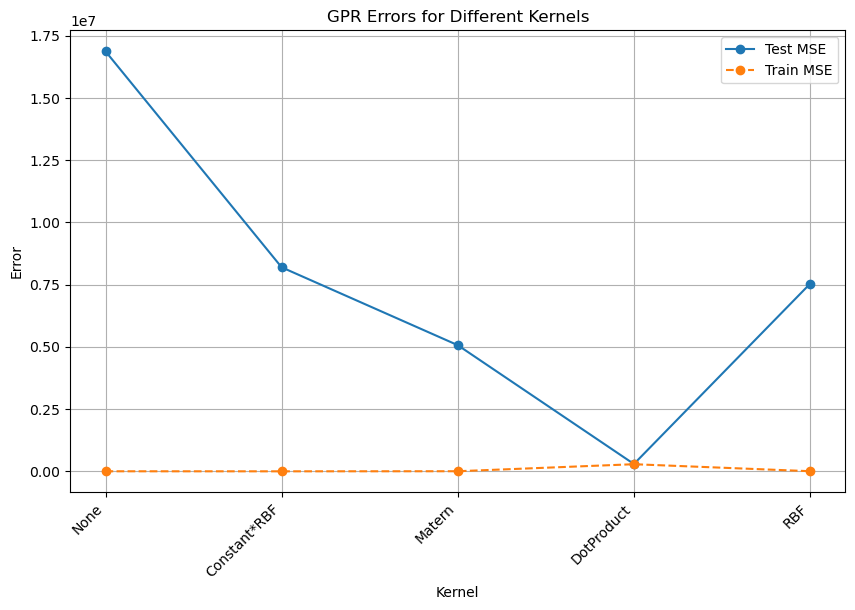

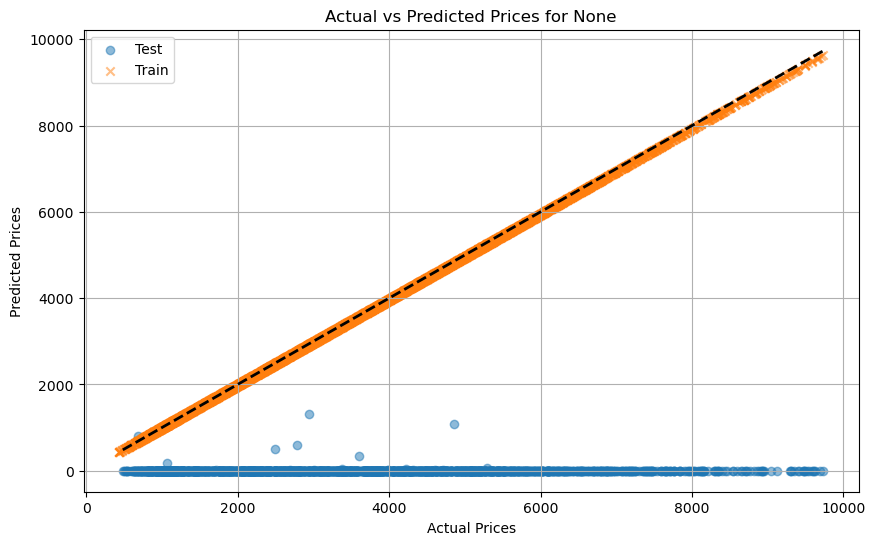

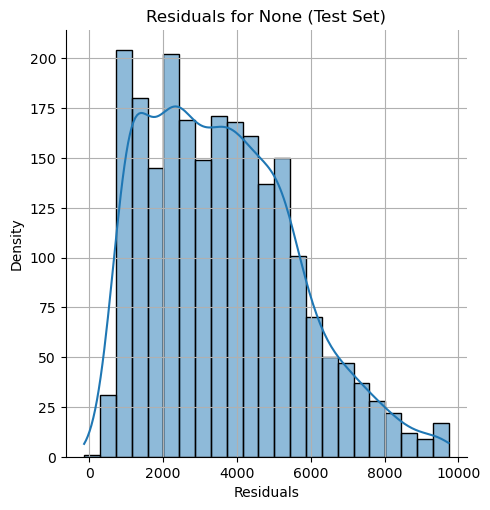

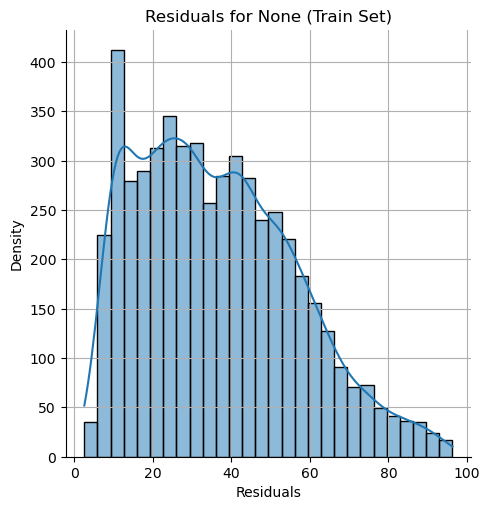

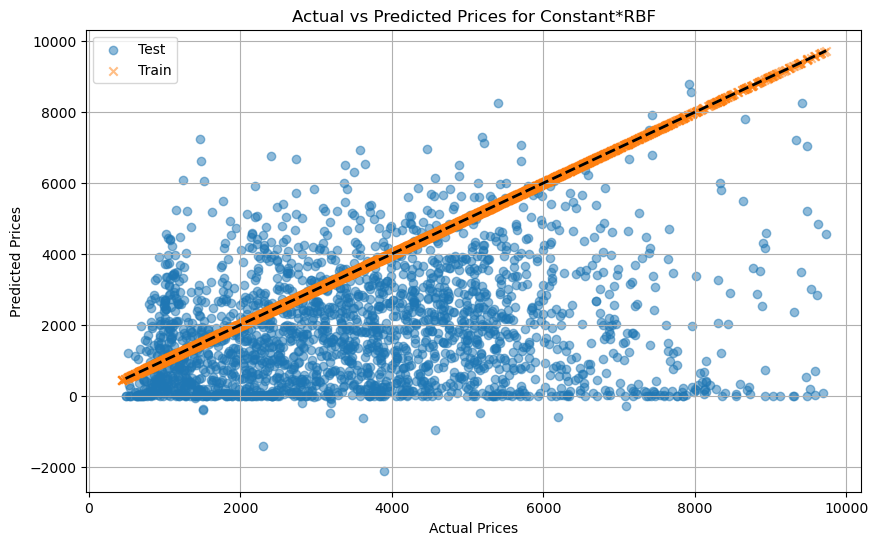

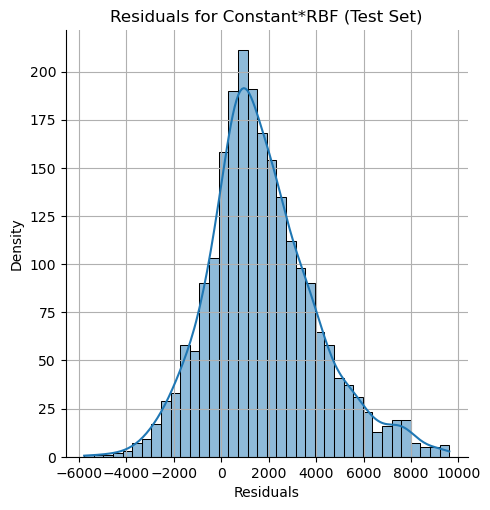

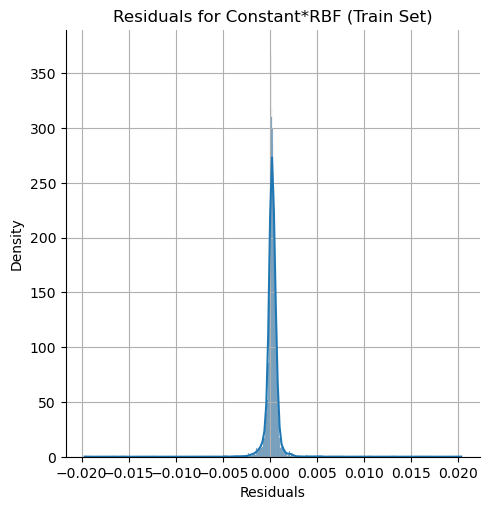

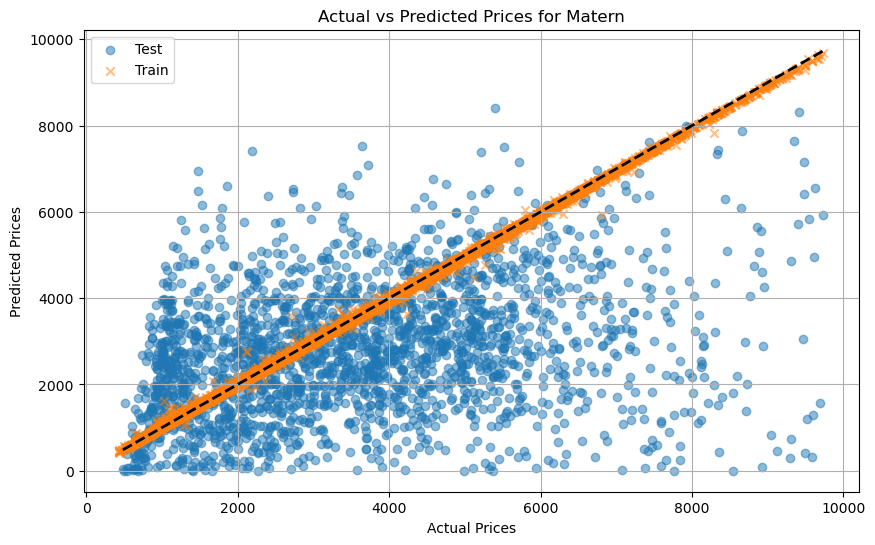

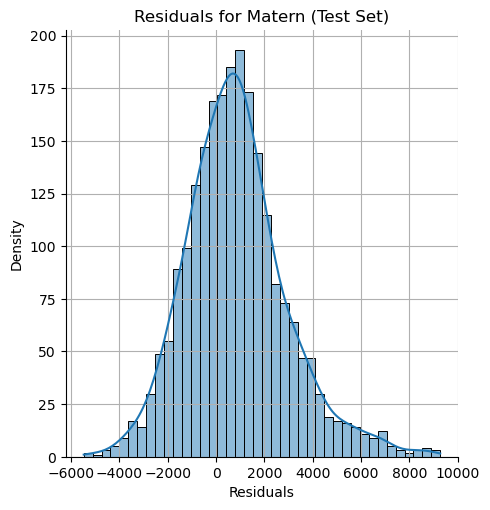

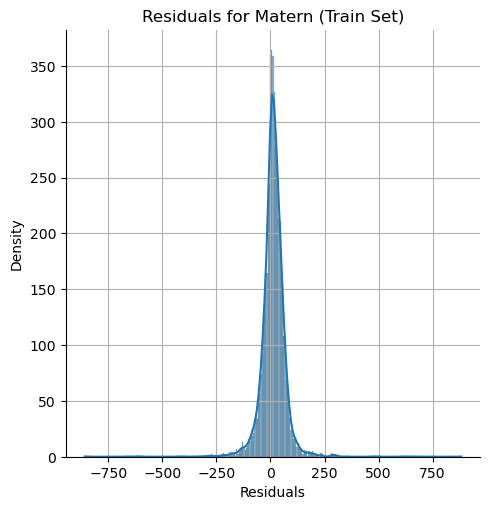

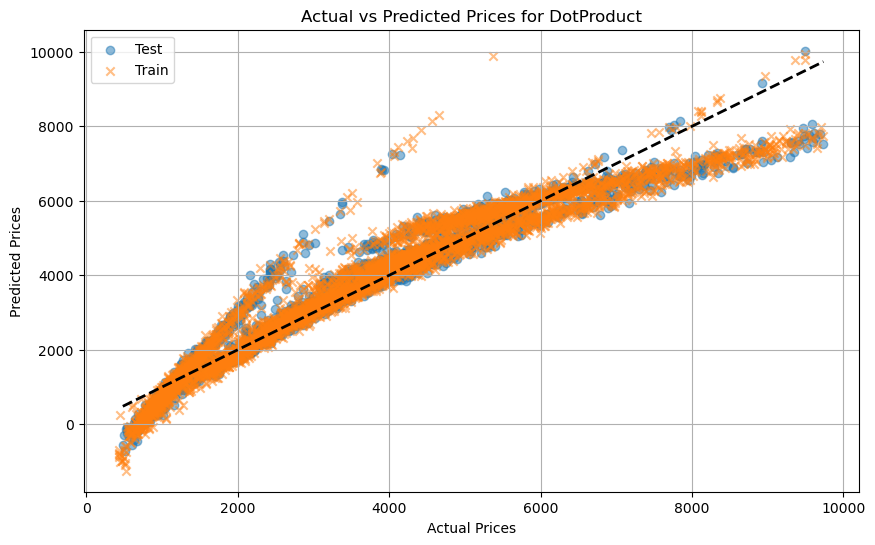

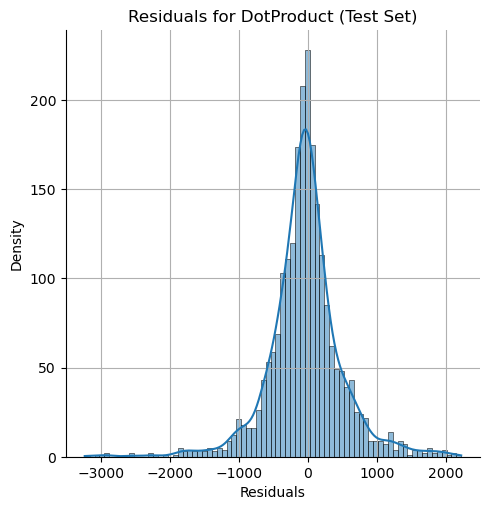

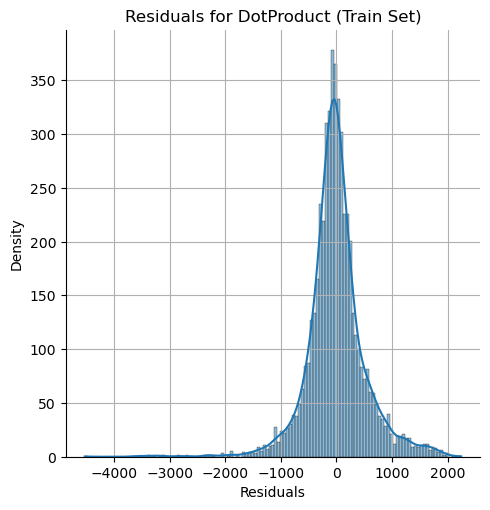

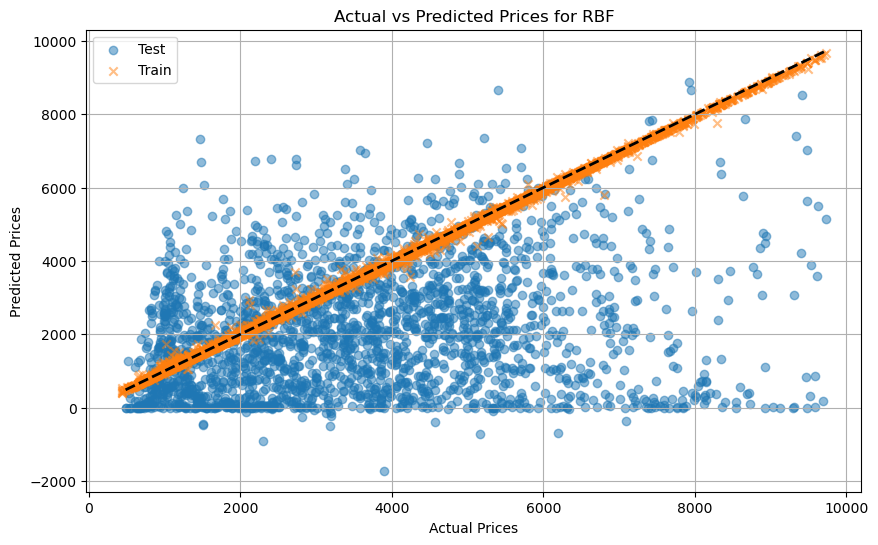

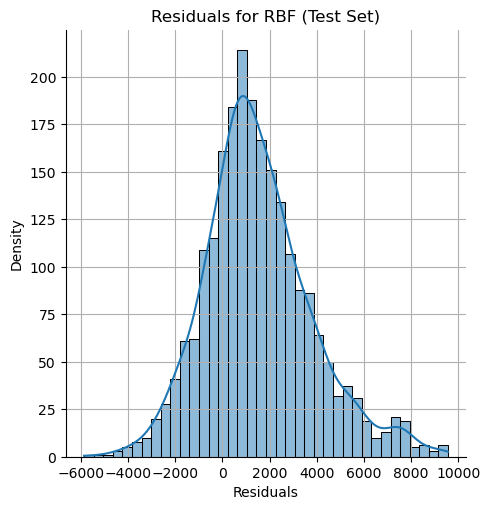

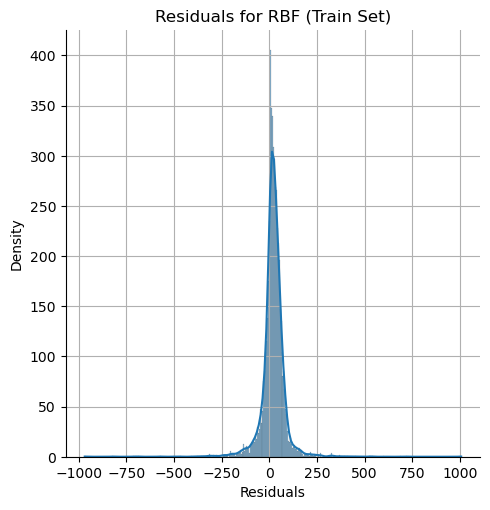

In [8]:
# Split the data into features and target variable
X = data.drop(columns=['price'])
y = data['price']

# Downsample the data if needed
sample_fraction = 0.1  # Adjust this fraction to reduce the dataset size even further
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=1-sample_fraction, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

# Define kernels to test
kernels = {
    "None": None,
    "Constant*RBF": C(1.0) * RBF(length_scale=1.0),
    "Matern": Matern(length_scale=1.0, nu=1.5),
    "DotProduct": DotProduct(),
    "RBF": RBF(length_scale=1.0),
}



results = {}

# Train and evaluate a Gaussian Process Regressor for each kernel
for kernel_name, kernel in kernels.items():
    print(f"Training with kernel: {kernel_name}")
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gpr.fit(X_train, y_train)
    
    y_pred_train = gpr.predict(X_train)
    y_pred_test = gpr.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    results[kernel_name] = {
        "train": {"mse": mse_train, "mae": mae_train, "r2": r2_train, "y_pred": y_pred_train},
        "test": {"mse": mse_test, "mae": mae_test, "r2": r2_test, "y_pred": y_pred_test}
    }

# Display the results
results_df_test = pd.DataFrame({
    "Kernel": [k for k in results.keys()],
    "Mean Squared Error": [results[k]["test"]["mse"] for k in results.keys()],
    "Mean Absolute Error": [results[k]["test"]["mae"] for k in results.keys()],
    "R^2": [results[k]["test"]["r2"] for k in results.keys()]
})

results_df_train = pd.DataFrame({
    "Kernel": [k for k in results.keys()],
    "Mean Squared Error": [results[k]["train"]["mse"] for k in results.keys()],
    "Mean Absolute Error": [results[k]["train"]["mae"] for k in results.keys()],
    "R^2": [results[k]["train"]["r2"] for k in results.keys()]
})

print("Test Set Results:")
print(results_df_test)

print("\nTrain Set Results:")
print(results_df_train)

# Plot the Mean Squared Error for different kernels for test set
plt.figure(figsize=(10, 6))
plt.plot(results_df_test['Kernel'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
plt.plot(results_df_train['Kernel'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
plt.title('GPR Errors for Different Kernels')
plt.xlabel('Kernel')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plots of actual vs predicted values for each kernel for both train and test sets
for kernel_str in results.keys():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, results[kernel_str]['test']['y_pred'], alpha=0.5, label='Test')
    plt.scatter(y_train, results[kernel_str]['train']['y_pred'], alpha=0.5, label='Train', marker='x')
    plt.title(f'Actual vs Predicted Prices for {kernel_str}')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot residuals for test set
    residuals_test = y_test - results[kernel_str]['test']['y_pred']
    sns.displot(residuals_test, kde=True)
    plt.title(f'Residuals for {kernel_str} (Test Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    # Plot residuals for train set
    residuals_train = y_train - results[kernel_str]['train']['y_pred']
    sns.displot(residuals_train, kde=True)
    plt.title(f'Residuals for {kernel_str} (Train Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
